### 1. Import torch and print out the version. 

Also check if we have a GPU available to make the code device agnostic

In [5]:
import torch
from torchvision import datasets
from torch import nn


In [6]:
print(torch.__version__)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


2.3.0
cpu


### 2. Load the dataset and visualize an image

In [7]:
## Load and print the first label
import json
import torchvision.transforms as transforms 

file="/Users/somye/Downloads/DataSetV1/RoundaboutInfo.json"
f = open(file)
data = json.load(f)
print(data[0])
print(len(data))
f.close
X=data[0]['X']
Y=data[0]['Y']

from  torchvision.io import read_image
image="/Users/somye/Downloads/DataSetV1/0000.png"
a=read_image(image)
print(a.shape[1])
print(a.shape[2])

# Uncomment the below code to plot an image
#import matplotlib.pyplot as plt
#plt.imshow(a.permute(1,2,0))  ## Matplotlib expects the channels to be the last dimension, we will reaarange our image to HXWXC
#plt.scatter(X,800-Y, s=50, c='red', marker='o')  ## 800-Y because our y-axis is inverted if you see


{'X': 181.01384, 'Y': 698.6175, 'rabR': 43.00092}
1000
800
800


### 3. Prepare a custom dataset
We will resize the images from 800X800 To --> `newsize`. <br>We will also convert it to greyscale<br>
We will also normalize the image labels by diving them by `newsize`
<br> Because we are scaling down the images to newsize, we also have to scale down our x,y,rabR labels ( so multiply them by (`newsize/origsize`) )

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from  torchvision.io import read_image
from PIL import Image
from torchvision import transforms
import json
from torchvision.transforms.functional import rgb_to_grayscale
import glob

class PrepareData(Dataset):
    def __init__(self,imagePath,transform=None):
        self.imagePath=imagePath
        self.transform = transform
        self.imgdict={}
        self.labeldict={}
        f = open(imagePath+"/RoundaboutInfo.json")
        labeldata = json.load(f)


        
        for i,img in enumerate(sorted(glob.glob(self.imagePath+'/*.png'))):
            self.imgdict[i]=Image.open(img)
            labeldata[i]['X']=labeldata[i]['X']*newsize/origsize
            labeldata[i]['Y']=newsize - labeldata[i]['Y']*newsize/origsize
            labeldata[i]['rabR']=labeldata[i]['rabR']*newsize/origsize

        
            labeldata[i]['X']= labeldata[i]['X']/newsize
            labeldata[i]['Y']= labeldata[i]['Y']/newsize
            labeldata[i]['rabR']=labeldata[i]['rabR']/newsize
            
            self.labeldict[i]=labeldata[i]

        f.close()

    def load_image(self,idx):
        return self.imgdict[idx]

    def __len__(self):
        return len(self.imgdict)

    def __getitem__(self,idx):
        if self.transform:
            return rgb_to_grayscale(self.transform(self.load_image(idx))), self.labeldict[idx]
        else:
            return self.load_image(idx), self.labeldict[idx]

imagePath="/Users/somye/Downloads/DataSetV1/"
origsize=800 ##   Fetch the width from original images
newsize=128  ## Set both height and width to 128
train_transforms = transforms.Compose([
    transforms.Resize((newsize, newsize)),
    transforms.ToTensor()
])


d=PrepareData(imagePath,train_transforms)
batch_size=100
train_size = int(0.90 * len(d))
test_size = len(d) - train_size
torch.manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(d, [train_size, test_size])
train_loader=DataLoader(train_dataset,batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size,shuffle=True)

In [9]:
## Print some samples
import matplotlib.pyplot as plt
for i,j in train_loader:
    print (i.shape)
    print(j['X'].shape)
    print(j['Y'].shape)
    print(j['rabR'].shape)
    #plt.imshow(i[0].permute(1, 2, 0))  ##Convert to H*W*C because matplotlib expects so
    #print(j)  #This will display the image tensors, if you uncomment this you will see that the data is normalized already by pytorch;s ToTensor() method
    #plt.scatter(j['X'][0]*128, j['Y'][0]*128, s=50, c='red', marker='o')
    print(j['X'][0],j['Y'][0])
    break

torch.Size([100, 1, 128, 128])
torch.Size([100])
torch.Size([100])
torch.Size([100])
tensor(0.3138, dtype=torch.float64) tensor(0.6523, dtype=torch.float64)


### Define a NeuralNetwork
We will use CNN in combination with FullyConnected dense layers

In [10]:
class CNN(nn.Module):
    def __init__(self,in_channels=1, hidden_units=32):
        super().__init__()
        self.in_channels=in_channels
        self.hidden_units=hidden_units
        self.cnnlayers=nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=20, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=7, stride=1),
            nn.LeakyReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout(),

            nn.Conv2d(in_channels=40, out_channels=80, padding=1,kernel_size=11, stride=1),
            nn.LeakyReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=2)
            
            
                                    )
        self.classifer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8000, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=3)

                                     )
    def forward(self, x):
            return self.classifer(self.cnnlayers(x))

            

### 4.1 Create our model object and pass random tensors to it that matches our image tensors.<br>
Check output size produced by our model. It outputs 3 labels per image (X,Y,rabR)

In [13]:
## Create a random image matching our data and check that the models returns a tuple of 3 values (X,Y,rabR)
modelV1=CNN()
randomimage=torch.rand(batch_size,1,128,128)
print(modelV1(randomimage).shape)

torch.manual_seed(42)
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

modelV1.apply(weights_init)


torch.Size([100, 3])


CNN(
  (cnnlayers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(40, 80, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8000, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_fea

### 4.2 Print the summary of our NN

In [1197]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

## You can view a details of the shapes here
from torchinfo import summary
summary(modelV1, input_size=[batch_size, 1, 128, 128]) # do a test pass through of an example input siz

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 3]                  --
├─Sequential: 1-1                        [100, 80, 10, 10]         --
│    └─Conv2d: 2-1                       [100, 20, 124, 124]       520
│    └─LeakyReLU: 2-2                    [100, 20, 124, 124]       --
│    └─LocalResponseNorm: 2-3            [100, 20, 124, 124]       --
│    └─MaxPool2d: 2-4                    [100, 20, 62, 62]         --
│    └─Conv2d: 2-5                       [100, 40, 56, 56]         39,240
│    └─LeakyReLU: 2-6                    [100, 40, 56, 56]         --
│    └─LocalResponseNorm: 2-7            [100, 40, 56, 56]         --
│    └─MaxPool2d: 2-8                    [100, 40, 28, 28]         --
│    └─Conv2d: 2-9                       [100, 80, 20, 20]         387,280
│    └─LeakyReLU: 2-10                   [100, 80, 20, 20]         --
│    └─LocalResponseNorm: 2-11           [100, 80, 20, 20]         --
│    

### 5.1 Define a train loop function that returns total avg loss per epoch

In [1198]:
def train_step(model, dataloader, loss_fn, optimizer):
    tloss=0
    model.train()
    for batch, (data,labels) in enumerate(dataloader):
        pred=model(data)

        loss=loss_fn(pred.type(torch.float64), torch.stack((labels['X'],labels['Y'],labels['rabR']),dim=0).permute(1,0))
        tloss+=loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tloss/=len(dataloader)
    return tloss.item()
        

### 5.2 Define loss functions, optimizers etc (hyperparameters)
Store the losses per epoch into a dictionary that we can use later to graph our losses over epochs

In [1199]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=modelV1.parameters(), lr=0.0001)
epochs=200

avgloss=[]
epochcnt=[]


for epoch in range(epochs):
    loss=train_step(modelV1, train_loader,loss_fn,optimizer)
    if epoch%10==0:
        print(f"Epoch:{epoch} | AvgLoss: {loss} ")
        avgloss.append(loss)
        epochcnt.append(epoch)



Epoch:0 | AvgLoss: 0.16664201687902921 
Epoch:10 | AvgLoss: 0.02076170040357617 
Epoch:20 | AvgLoss: 0.020200565996935205 
Epoch:30 | AvgLoss: 0.01357837289030389 
Epoch:40 | AvgLoss: 0.010257941285846249 
Epoch:50 | AvgLoss: 0.009391138685196433 
Epoch:60 | AvgLoss: 0.00897871288263105 
Epoch:70 | AvgLoss: 0.008809790931981401 
Epoch:80 | AvgLoss: 0.008537269348036077 
Epoch:90 | AvgLoss: 0.008041741673736148 
Epoch:100 | AvgLoss: 0.007463005863069507 
Epoch:110 | AvgLoss: 0.0070456575822990825 
Epoch:120 | AvgLoss: 0.006777687964814184 
Epoch:130 | AvgLoss: 0.006526186289006021 
Epoch:140 | AvgLoss: 0.006187437461219942 
Epoch:150 | AvgLoss: 0.005905022866357033 
Epoch:160 | AvgLoss: 0.005654793322760414 
Epoch:170 | AvgLoss: 0.00539255208643671 
Epoch:180 | AvgLoss: 0.005038234331806467 
Epoch:190 | AvgLoss: 0.004803444282765769 


### 5.3 Save the model

In [1208]:
path="/Users/somye/Downloads/DataSetV1/cnn1.pth"
torch.save(modelV1.state_dict(), path)

In [11]:
# modelV2 = CNN()
# modelV2.load_state_dict(torch.load("/Users/somye/Downloads/DataSetV1/cnn.pth"))


### 6.1 Pass the test_loader images to our model and visualize the output

In [14]:
import random
def predict_output(dataloader):
    modelV1.eval()
    with torch.inference_mode():
        rand=random.randint(0,32)

        for batch, (data,labels) in enumerate(dataloader):
            print(data.shape)
            print(data[rand].unsqueeze(dim=0).shape)
            out=modelV1(data[rand].unsqueeze(dim=0))
            print(f"Actual data: {labels['X'][rand]} , {labels['Y'][rand]} , {labels['rabR'][rand]}")
            print(f"Predicted data: {out[0][0].item()} , {out[0][1].item()} , {out[0][2].item()}")
            #plt.imshow(data[rand].permute(1,2,0))
            #plt.scatter(out[0][0].item()*newsize, out[0][1].item()*newsize, s=75, c='red', marker='o')  ## Predicted labels scale them back
            #plt.scatter(labels['X'][rand]*newsize, labels['Y'][rand]*newsize, s=50, c='yellow', marker='X')  ##True labels scale them back
            break

predict_output(test_loader)

torch.Size([100, 1, 128, 128])
torch.Size([1, 1, 128, 128])
Actual data: 0.85881625 , 0.57176322875 , 0.051669540375
Predicted data: -0.004876434803009033 , 0.3948831260204315 , 0.42042890191078186


### 6.2 Display the loss curve over epochs

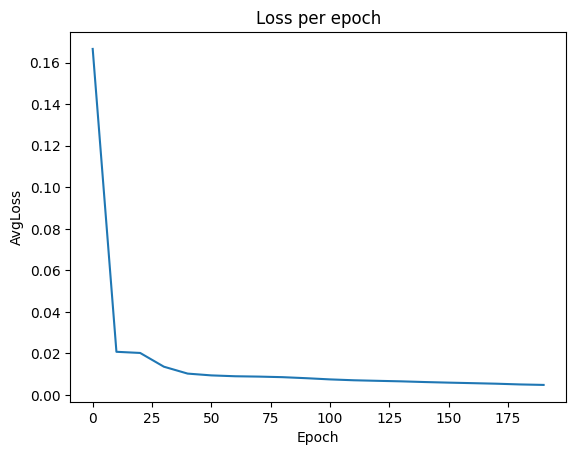

In [1204]:
plt.xlabel("Epoch")
plt.ylabel("AvgLoss")
plt.title("Loss per epoch")
plt.plot(epochcnt, avgloss)